In [1]:
import random
import string
from dataclasses import dataclass
from pathlib import Path

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm

import precip
import wandb
from precip.config import LOCAL_PRECIP_BOUNDARY_MASK
from precip.data.dataset import InfiniteSampler, SwedishPrecipitationDataset, npy_loader
from precip.models.conv_lstm.model import ConvLSTM
from einops import rearrange
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


@dataclass(frozen=True)
class ModelConfigUNet:
    model_name: str = 'convlstm_full_prototype'
    batch_size: int = 2
    number_of_steps: int = 20
    training_size_per_step: int = 1_000
    validation_size_per_step: int = 300
    lr: float = 5.34e-03
    lr_scheduler_step: int = 3
    lr_scheduler_gamma: float = 0.85
    weight_decay: float = 1e-4
    
def parse_args() -> ModelConfigUNet:
    return ModelConfigUNet()


In [2]:

config = parse_args()

# wandb.init(
#     # set the wandb project where this run will be logged
#     project="precip",
#     # track hyperparameters and run metadata
#     config=config.__dict__,
# )

training_dataset = SwedishPrecipitationDataset(split="train", scale=True, apply_mask_to_zero=True, insert_channel_dimension=True)
validation_dataset = SwedishPrecipitationDataset(split="val", scale=True, apply_mask_to_zero=True, insert_channel_dimension=True)

training_sampler = InfiniteSampler(training_dataset, shuffle=True)
validation_sampler = InfiniteSampler(validation_dataset, shuffle=True)

dataloader = DataLoader(
    training_dataset, sampler=training_sampler, batch_size=2, num_workers=12
)
val_dataloader = DataLoader(
    validation_dataset, sampler=validation_sampler, batch_size=2, num_workers=12
)
train_dataiter, val_dataiter = iter(dataloader), iter(val_dataloader)


In [33]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()

        self.c1 = nn.Conv2d(1, 8, 7, 5, 1)
        self.clstm1 = ConvLSTM(8, 64, 3, 1)
        self.c2 = nn.Conv2d(64, 192, 5, 1, 1)
        self.clstm2 = ConvLSTM(192, 192, 3, 1)
        self.c3 = nn.Conv2d(192, 192, 3, 2, 1)
        self.clstm3 = ConvLSTM(192, 192, 3, 1)

        self.declstm1 = ConvLSTM(192, 192, 3, 1)
        # self.dec1 = nn.ConvTranspose2d(192, 192, 3, 2, 1)
        self.dec1 = nn.UpsamplingBilinear2d(scale_factor=2.0)
        self.declstm2 = ConvLSTM(192, 64, 3, 1)
        # self.dec2 = nn.ConvTranspose2d(192, 64, 5, 1, 1)
        self.dec2 = nn.UpsamplingBilinear2d(scale_factor=2.0)
        self.declstm3 = ConvLSTM(64, 8, 3, 1)
        self.output = nn.Sequential(
            # nn.ConvTranspose2d(64, 8, 7, 5, 1),
            nn.UpsamplingBilinear2d(scale_factor=2.0),
            nn.Conv2d(8, 1, 1, 1, 1),
            # nn.Conv2d(8, 1, 1, 1, 0),
        )

    def forward(self, x):
        b, t, c, h, w = x.size()
        x1 = rearrange(x, "b t c h w -> (b t) c h w")

        z1 = rearrange(self.c1(x1), "(b t) c h w -> b t c h w", b=b, t=t)
        w1, _ = self.clstm1(z1)

        b, t, c, h, w = w1.size()
        x2 = rearrange(w1, "b t c h w -> (b t) c h w")
        z2 = rearrange(self.c2(x2), "(b t) c h w -> b t c h w", b=b, t=t)
        w2, _ = self.clstm2(z2)

        b, t, c, h, w = w2.size()
        x3 = rearrange(w2, "b t c h w -> (b t) c h w")
        z3 = rearrange(self.c3(x3), "(b t) c h w -> b t c h w", b=b, t=t)
        w3, _ = self.clstm3(z3)

        w3 = w3[:, :, :, 3:-3, 3:-3]

        d3, _ = self.declstm1(w3)
        b, t, c, h, w = d3.size()
        f3 = rearrange(
            self.dec1(rearrange(d3, "b t c h w -> (b t) c h w")),
            "(b t) c h w -> b t c h w",
            b=b,
            t=t,
        )

        d2, _ = self.declstm2(f3)
        b, t, c, h, w = d2.size()
        f2 = rearrange(
            self.dec2(rearrange(d2, "b t c h w -> (b t) c h w")),
            "(b t) c h w -> b t c h w",
            b=b,
            t=t,
        )

        d1, _ = self.declstm3(f2)
        b, t, c, h, w = d1.size()
        out = rearrange(
            self.output(rearrange(d1, "b t c h w -> (b t) c h w")),
            "(b t) c h w -> b t c h w",
            b=b,
            t=t,
        )

        out = F.interpolate(out, [1, 881, 458], mode="trilinear", align_corners=True)
        out = torch.mean(out, dim=1)

        return out
    
    
class BaseModel(nn.Module):
    def forward(self, x: torch.Tensor):
        return x.select(dim=1, index=-1)

In [18]:
model = Model().to(device).load_state_dict(torch.load("checkpoints/snowy-vortex-33NVZ2N/step_num_59")['model_state_dict'])

In [24]:
model = Model()
model.load_state_dict(torch.load("checkpoints/snowy-vortex-33NVZ2N/step_num_59")['model_state_dict'])
model.eval()

Model(
  (c1): Conv2d(1, 8, kernel_size=(7, 7), stride=(5, 5), padding=(1, 1))
  (clstm1): ConvLSTM(
    (cell_list): ModuleList(
      (0): ConvLSTMCell(
        (conv): Conv2d(72, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
      )
    )
  )
  (c2): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (clstm2): ConvLSTM(
    (cell_list): ModuleList(
      (0): ConvLSTMCell(
        (conv): Conv2d(384, 768, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
      )
    )
  )
  (c3): Conv2d(192, 192, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (clstm3): ConvLSTM(
    (cell_list): ModuleList(
      (0): ConvLSTMCell(
        (conv): Conv2d(384, 768, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
      )
    )
  )
  (declstm1): ConvLSTM(
    (cell_list): ModuleList(
      (0): ConvLSTMCell(
        (conv): Conv2d(384, 768, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_m

In [27]:
base_model = BaseModel().to(device)
model = model.to(device)

In [36]:
m1_loss = list()
m2_loss = list()

number_of_batches = 1_000
loss = nn.MSELoss()

with torch.no_grad():
    validation_loss_history = list()

    for _ in tqdm(range(number_of_batches)):
        batch_X, batch_y = next(train_dataiter)
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        out1 = model(batch_X)
        out2 = base_model(batch_X)
        m1_loss.append(loss(out1, batch_y).item())
        m2_loss.append(loss(out2, batch_y).item())

100%|██████████| 1000/1000 [02:43<00:00,  6.13it/s]


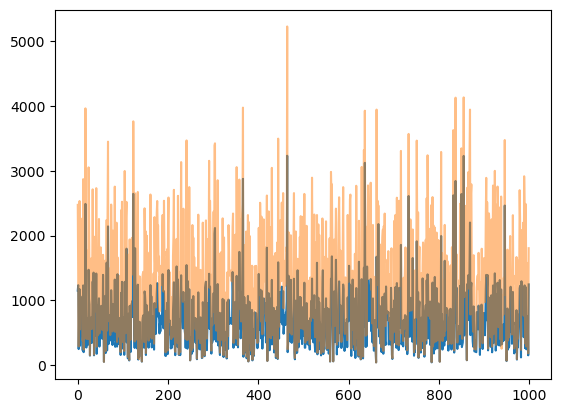

In [32]:
import matplotlib.pyplot as plt

plt.plot(m1_loss)
plt.plot(m2_loss, alpha=0.5)

In [ ]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()

        self.c1 = nn.Conv2d(1, 8, 7, 5, 1)
        self.clstm1 = ConvLSTM(8, 64, 3, 1)
        self.c2 = nn.Conv2d(64, 192, 5, 1, 1)
        self.clstm2 = ConvLSTM(192, 192, 3, 1)
        self.c3 = nn.Conv2d(192, 192, 3, 2, 1)
        self.clstm3 = ConvLSTM(192, 192, 3, 1)

        self.declstm1 = ConvLSTM(192, 192, 3, 1)
        # self.dec1 = nn.ConvTranspose2d(192, 192, 3, 2, 1)
        self.dec1 = nn.UpsamplingBilinear2d(scale_factor=2.0)
        self.declstm2 = ConvLSTM(192*2, 64, 3, 1)
        # self.dec2 = nn.ConvTranspose2d(192, 64, 5, 1, 1)
        self.dec2 = nn.UpsamplingBilinear2d(scale_factor=2.0)
        self.declstm3 = ConvLSTM(64*2, 8, 3, 1)
        self.output = nn.Sequential(
            # nn.ConvTranspose2d(64, 8, 7, 5, 1),
            nn.UpsamplingBilinear2d(scale_factor=2.0),
            nn.Conv2d(8, 1, 1, 1, 1),
            # nn.Conv2d(8, 1, 1, 1, 0),
        )

    def forward(self, x):
        b, t, c, h, w = x.size()
        x1 = rearrange(x, "b t c h w -> (b t) c h w")

        z1 = rearrange(self.c1(x1), "(b t) c h w -> b t c h w", b=b, t=t)
        w1, _ = self.clstm1(z1)

        b, t, c, h, w = w1.size()
        x2 = rearrange(w1, "b t c h w -> (b t) c h w")
        z2 = rearrange(self.c2(x2), "(b t) c h w -> b t c h w", b=b, t=t)
        w2, _ = self.clstm2(z2)

        b, t, c, h, w = w2.size()
        x3 = rearrange(w2, "b t c h w -> (b t) c h w")
        z3 = rearrange(self.c3(x3), "(b t) c h w -> b t c h w", b=b, t=t)
        w3, _ = self.clstm3(z3)

        w3 = w3[:, :, :, 3:-3, 3:-3]

        d3, _ = self.declstm1(w3)
        b, t, c, h, w = d3.size()
        f3 = rearrange(
            self.dec1(rearrange(d3, "b t c h w -> (b t) c h w")),
            "(b t) c h w -> b t c h w",
            b=b,
            t=t,
        )

        d2, _ = self.declstm2(f3)
        b, t, c, h, w = d2.size()
        f2 = rearrange(
            self.dec2(rearrange(d2, "b t c h w -> (b t) c h w")),
            "(b t) c h w -> b t c h w",
            b=b,
            t=t,
        )

        d1, _ = self.declstm3(f2)
        b, t, c, h, w = d1.size()
        out = rearrange(
            self.output(rearrange(d1, "b t c h w -> (b t) c h w")),
            "(b t) c h w -> b t c h w",
            b=b,
            t=t,
        )

        out = F.interpolate(out, [1, 881, 458], mode="trilinear", align_corners=True)
        out = torch.mean(out, dim=1)

        return out

In [3]:

mask = (~npy_loader(LOCAL_PRECIP_BOUNDARY_MASK)).to(device)
# model = Model().to(device)

loss = nn.MSELoss()
optimizer = optim.Adam(
    model.parameters(),
    lr=config.lr,
    weight_decay=config.weight_decay,
)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=config.lr_scheduler_gamma)

def train(number_of_batches: int = 1_000) -> float:
    model.train()
    loss_history = list()

    for _ in tqdm(range(number_of_batches)):
        (batch_X, batch_y) = next(train_dataiter)
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        out = model(batch_X)
        out.register_hook(lambda grad: grad * mask)
        _loss = loss(out, batch_y)
        _loss.backward()
        optimizer.step()
        loss_history.append(_loss.item())

    return np.mean(loss_history)

@torch.no_grad()
def test(number_of_batches: int = 300) -> float:
    model.eval()
    validation_loss_history = list()

    for _ in tqdm(range(number_of_batches)):
        batch_X, batch_y = next(val_dataiter)
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        out = model(batch_X)
        validation_loss_history.append(loss(out, batch_y).item())
    return np.mean(validation_loss_history)

# folder_name = (
#     Path(precip.__file__).parents[1]
#     / "checkpoints"
#     / (wandb.run.name + "".join(random.choices(string.ascii_uppercase + string.digits, k=5)))
# )
# folder_name.mkdir(parents=True, exist_ok=True)

# for step_num in range(0, config.number_of_steps):
#     train_loss = train(config.training_size_per_step)
#     val_loss = test(config.validation_size_per_step)
#     scheduler.step()

#     number_of_obs = (
#         config.batch_size
#         * config.training_size_per_step
#         * config.number_of_steps
#         * (step_num + 1)
#     )

#     torch.save(
#         {
#             "total_number_observations": number_of_obs,
#             "model_state_dict": model.state_dict(),
#             "optimizer_state_dict": optimizer.state_dict(),
#             "train_loss": train_loss,
#             "val_loss": val_loss,
#         },
#         folder_name / f"step_num_{step_num}",
#     )

#     # wandb.log({"loss": {"train": np.mean(train_loss), "val": np.mean(val_loss)}})

NameError: name 'model' is not defined

In [4]:
(batch_X, batch_y) = next(train_dataiter)
batch_X, batch_y = batch_X.to(device), batch_y.to(device)

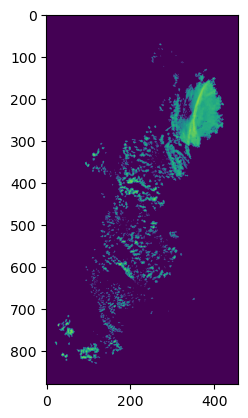

In [5]:
import matplotlib.pyplot as plt
plt.imshow(batch_X[0, 0, 0].detach().cpu().numpy())

In [13]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()

        self.c1 = nn.Conv2d(1, 8, 7, 5, 1)
        self.clstm1 = ConvLSTM(8, 64, 3, 1)
        self.c2 = nn.Conv2d(64, 192, 5, 1, 1)
        self.clstm2 = ConvLSTM(192, 192, 3, 1)
        self.c3 = nn.Conv2d(192, 192, 3, 2, 1)
        self.clstm3 = ConvLSTM(192, 192, 3, 1)

        self.declstm1 = ConvLSTM(192, 192, 3, 1)
        # self.dec1 = nn.ConvTranspose2d(192, 192, 3, 2, 1)
        self.dec1 = nn.UpsamplingBilinear2d(scale_factor=2.0)
        self.declstm2 = ConvLSTM(192, 64, 3, 1)
        # self.dec2 = nn.ConvTranspose2d(192, 64, 5, 1, 1)
        self.dec2 = nn.UpsamplingBilinear2d(scale_factor=2.0)
        self.declstm3 = ConvLSTM(64, 8, 3, 1)
        self.output = nn.Sequential(
            # nn.ConvTranspose2d(64, 8, 7, 5, 1),
            nn.UpsamplingBilinear2d(scale_factor=2.0),
            nn.Conv2d(8, 1, 1, 1, 1),
            # nn.Conv2d(8, 1, 1, 1, 0),
        )

    def forward(self, x):
        b, t, c, h, w = x.size()
        x1 = rearrange(x, "b t c h w -> (b t) c h w")

        z1 = rearrange(self.c1(x1), "(b t) c h w -> b t c h w", b=b, t=t)
        w1, _ = self.clstm1(z1)

        b, t, c, h, w = w1.size()
        x2 = rearrange(w1, "b t c h w -> (b t) c h w")
        z2 = rearrange(self.c2(x2), "(b t) c h w -> b t c h w", b=b, t=t)
        w2, _ = self.clstm2(z2)

        b, t, c, h, w = w2.size()
        x3 = rearrange(w2, "b t c h w -> (b t) c h w")
        z3 = rearrange(self.c3(x3), "(b t) c h w -> b t c h w", b=b, t=t)
        w3, _ = self.clstm3(z3)

        w3 = w3[:, :, :, 3:-3, 3:-3]

        d3, _ = self.declstm1(w3)
        b, t, c, h, w = d3.size()
        f3 = rearrange(
            self.dec1(rearrange(d3, "b t c h w -> (b t) c h w")),
            "(b t) c h w -> b t c h w",
            b=b,
            t=t,
        )

        d2, _ = self.declstm2(f3)
        b, t, c, h, w = d2.size()
        f2 = rearrange(
            self.dec2(rearrange(d2, "b t c h w -> (b t) c h w")),
            "(b t) c h w -> b t c h w",
            b=b,
            t=t,
        )

        d1, _ = self.declstm3(f2)
        b, t, c, h, w = d1.size()
        out = rearrange(
            self.output(rearrange(d1, "b t c h w -> (b t) c h w")),
            "(b t) c h w -> b t c h w",
            b=b,
            t=t,
        )

        out = F.interpolate(out, [1, 881, 458], mode="trilinear", align_corners=True)
        out = torch.mean(out, dim=1)

        return out

In [14]:
model = Model().to(device)

In [ ]:
base

In [17]:
d1.shape

torch.Size([2, 4, 8, 324, 156])

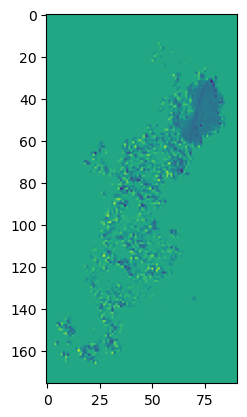

In [18]:
plt.imshow(z1[0, 0, 0].detach().cpu().numpy())

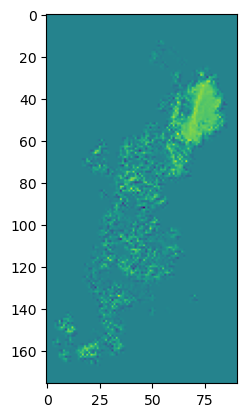

In [19]:
plt.imshow(w1[0, 0, 0].detach().cpu().numpy())

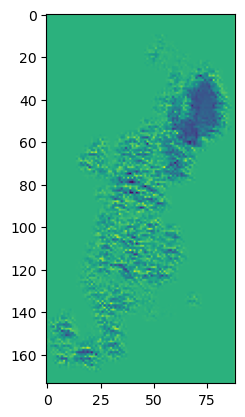

In [20]:
plt.imshow(z2[0, 0, 0].detach().cpu().numpy())

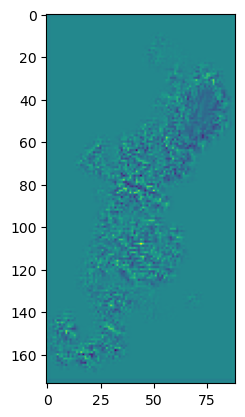

In [21]:
plt.imshow(w2[0, 0, 0].detach().cpu().numpy())

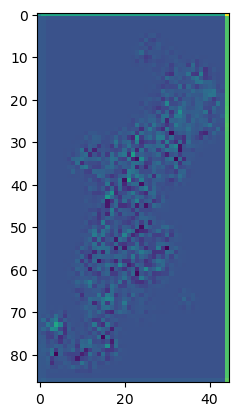

In [22]:
plt.imshow(z3[0, 0, 0].detach().cpu().numpy())

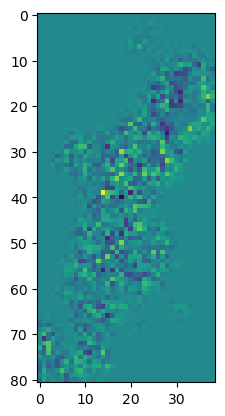

In [23]:
plt.imshow(w3[0, 0, 0].detach().cpu().numpy())

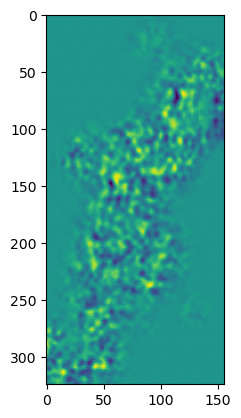

In [24]:
plt.imshow(d1[0, 0, 0].detach().cpu().numpy())

In [26]:
out.shape

torch.Size([2, 1, 881, 458])

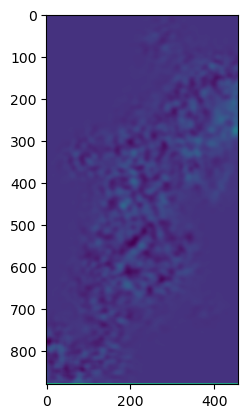

In [27]:
plt.imshow(out[0, 0].detach().cpu().numpy())

In [ ]:
model.train()
loss_history = list()

for _ in tqdm(range(number_of_batches)):
    (batch_X, batch_y) = next(train_dataiter)
    batch_X, batch_y = batch_X.to(device), batch_y.to(device)
    optimizer.zero_grad()
    out = model(batch_X)
    out.register_hook(lambda grad: grad * mask)
    _loss = loss(out, batch_y)
    _loss.backward()
    optimizer.step()
    loss_history.append(_loss.item())

return np.mean(loss_history)